# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [1]:
# Install necessary packages
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install missingno
# %pip install imblearn
# %pip install xgboost
# %pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings('ignore')

import functions as fc

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Loading data

In [3]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

test_data_pred_col = list(test_data['date_hour'])

# 2. Inspecting data

## 2.1 Showing datasets

In [4]:
train_data.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [6]:
train_data.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


The datasets contains no missing data.

The columns in the dataset are predominantly of data types `int` or `float`, except for the `date_hour` column, which is of type `object`. This column will need to be converted to the `datetime` format for further analysis.

## 2.2 Inspecting individual columns

In [7]:
cols = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

dv_train = fc.DataVisualizer(train_data)

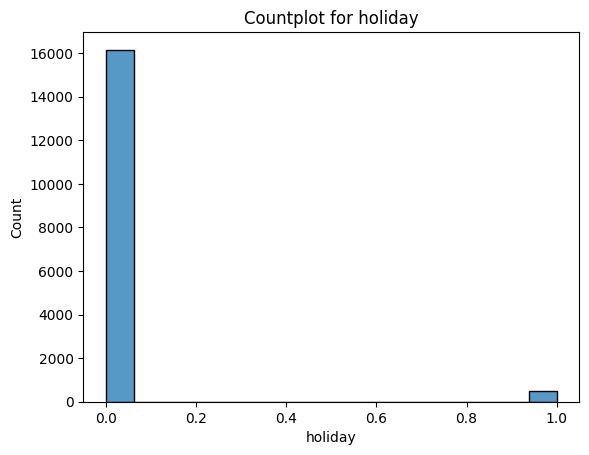

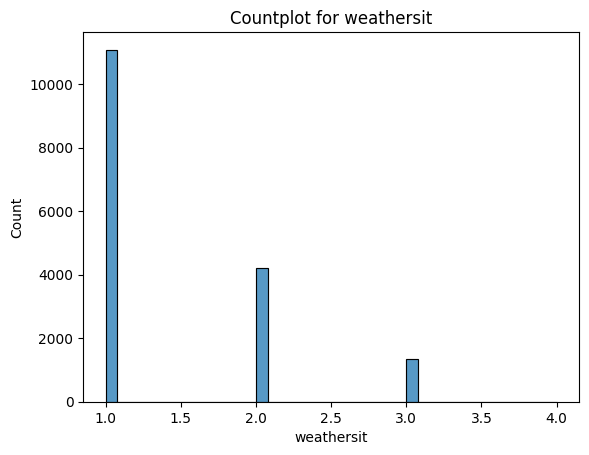

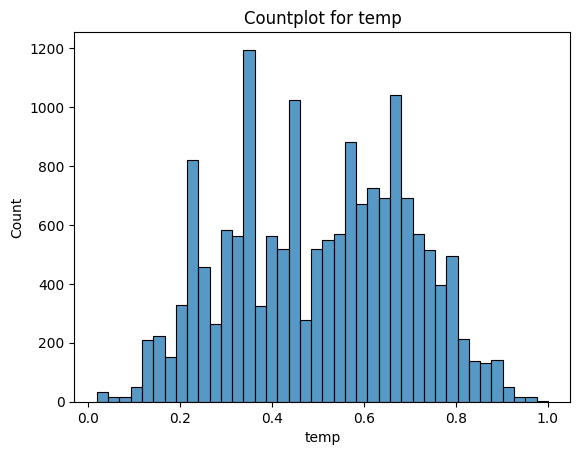

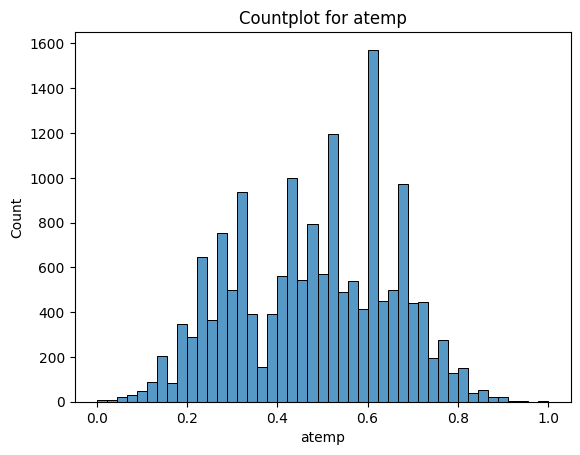

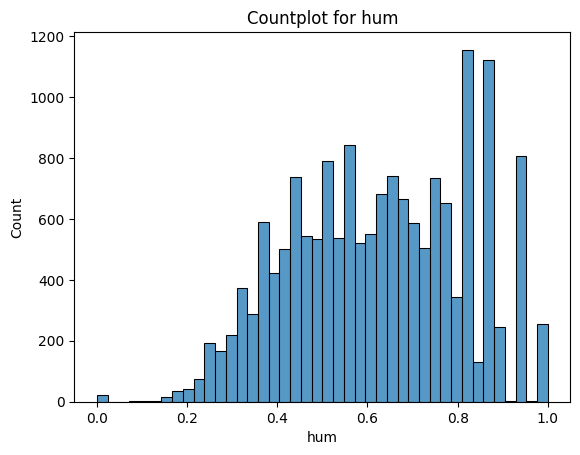

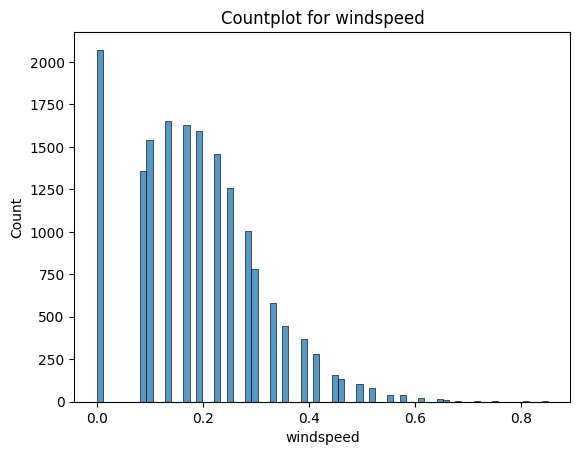

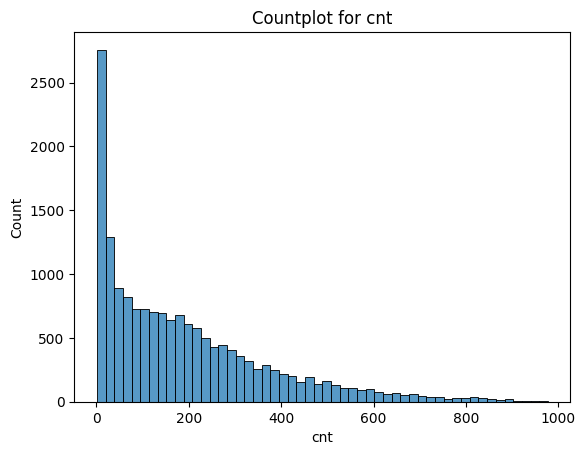

In [8]:
dv_train.plot_distribution(cols, 'train_data')

1. **Countplot for `holiday`:**
    - **Majority of entries are non-holidays**: The count for `0` (non-holidays) is significantly higher than `1` (holidays), indicating that most of the data represents regular working or non-holiday days.
2. **Countplot for `weathersit`:**
    - **Category 1 dominates**: Most observations fall into category `1`, representing favorable or clear weather.
    - **Category 2 and 3 are less common**: These represent moderate or less favorable weather conditions.
    - **Category 4 is absent**: These imply extreme weather conditions are not present in the dataset.
3. **Countplot for `temp`:**
    - This column is normally distributed.
4. **Countplot for `atemp`:**
    - This column is normally distributed.
5. **Countplot for `hum`:**
    - This column is left skewed.
6. **Countplot for `windspeed`:**
    - This column is right skewed.
7. **Countplot for `cnt`:**
    - Most of the amounts for cnt are nearer to zero, indicating that higher amounts for `cnt` are preserved for specific occassions.

## 2.3 Relationships between variables

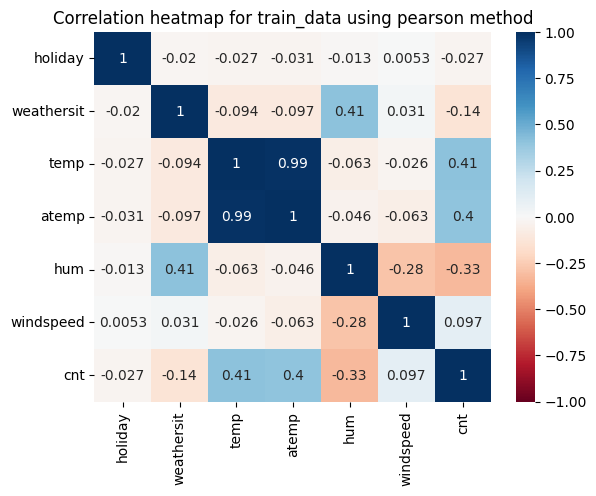

In [9]:
dv_train.plot_correlation('train_data', method='pearson')

The target variable `cnt` exhibits the following correlations with the other features in the dataset:

1. **`temp` (Temperature)**:
   - Correlation: **0.41** (moderate positive)
   - Interpretation: As temperature increases, the count of rentals tends to increase. This suggests that warmer weather is favorable for usage.

2. **`atemp` (Feels-like Temperature)**:
   - Correlation: **0.4** (moderate positive)
   - Interpretation: Similar to `temp`, higher feels-like temperatures are associated with more rentals. Since `temp` and `atemp` are highly correlated with each other, their impact on `cnt` is quite similar.

3. **`hum` (Humidity)**:
   - Correlation: **-0.33** (moderate negative)
   - Interpretation: Higher humidity levels are associated with a decrease in rentals. This indicates that humid weather may discourage people from renting.

4. **`windspeed`**:
   - Correlation: **0.097** (weak positive)
   - Interpretation: Windspeed shows a very weak positive correlation with rentals. This suggests that windspeed has a minimal linear relationship with the count of rentals.

5. **`weathersit` (Weather Situation)**:
   - Correlation: **-0.14** (weak negative)
   - Interpretation: Since this column is a column consisting of four classes, a pearson correlation coefficient is not the best way to figure out relations.

6. **`holiday`**:
   - Correlation: **-0.027** (very weak negative)
   - Interpretation: The correlation between holidays and rentals is negligible, indicating that the number of rentals is not significantly affected by whether it is a holiday. Although, here again it is a column consisting of two classes, therefore, a pearson correlation coefficient is not the best way to find out relations.

**Summary:**
- The most significant predictors of `cnt` are `temp` (0.41), `atemp` (0.4), and `hum` (-0.33), as these exhibit moderate correlations.
   - Since `temp` and `atemp` have a high correlation towards eachothter (0.99), one of them can be rendered negligible.
- Features such as `windspeed`, `weathersit`, and `holiday` show weak or negligible correlations, indicating they may have limited linear influence on the target variable.

## 2.4 Inspecting trends, and seasonal components

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [10]:
train_dc = fc.TimeSeriesDecomposer(train_data['cnt'], period=24)

In [11]:
trend, seasonal, residual = train_dc.decompose()

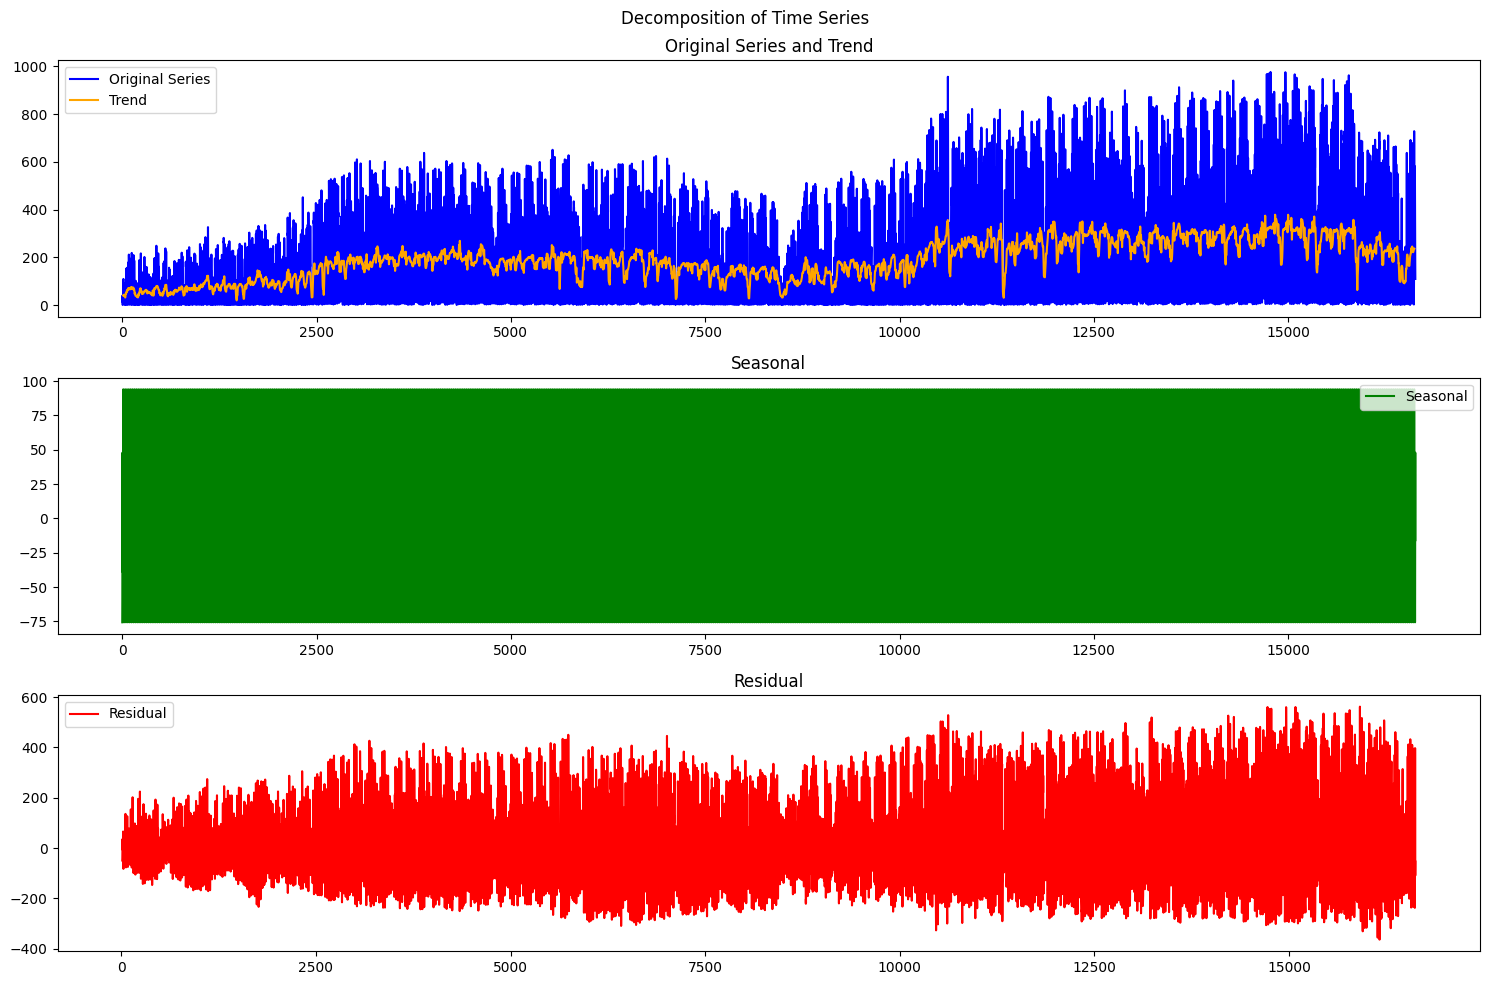

In [12]:
train_dc.plot_decomposition(trend, seasonal, residual)

The plot above does not clearly reveal a seasonally repeating pattern, it is currently commented out due to runtime. This is likely due to the extensive amount of data, as it encompasses hourly observations over a two-year period. To facilitate the identification of seasonal patterns, a new decomposition will be performed on a subset comprising one-thirtysecond of the dataset.


In [13]:
train_dc_1 = fc.TimeSeriesDecomposer(train_data.iloc[:int(len(train_data)/32), :]['cnt'], period=24)

In [14]:
trend, seasonal, residual = train_dc_1.decompose()

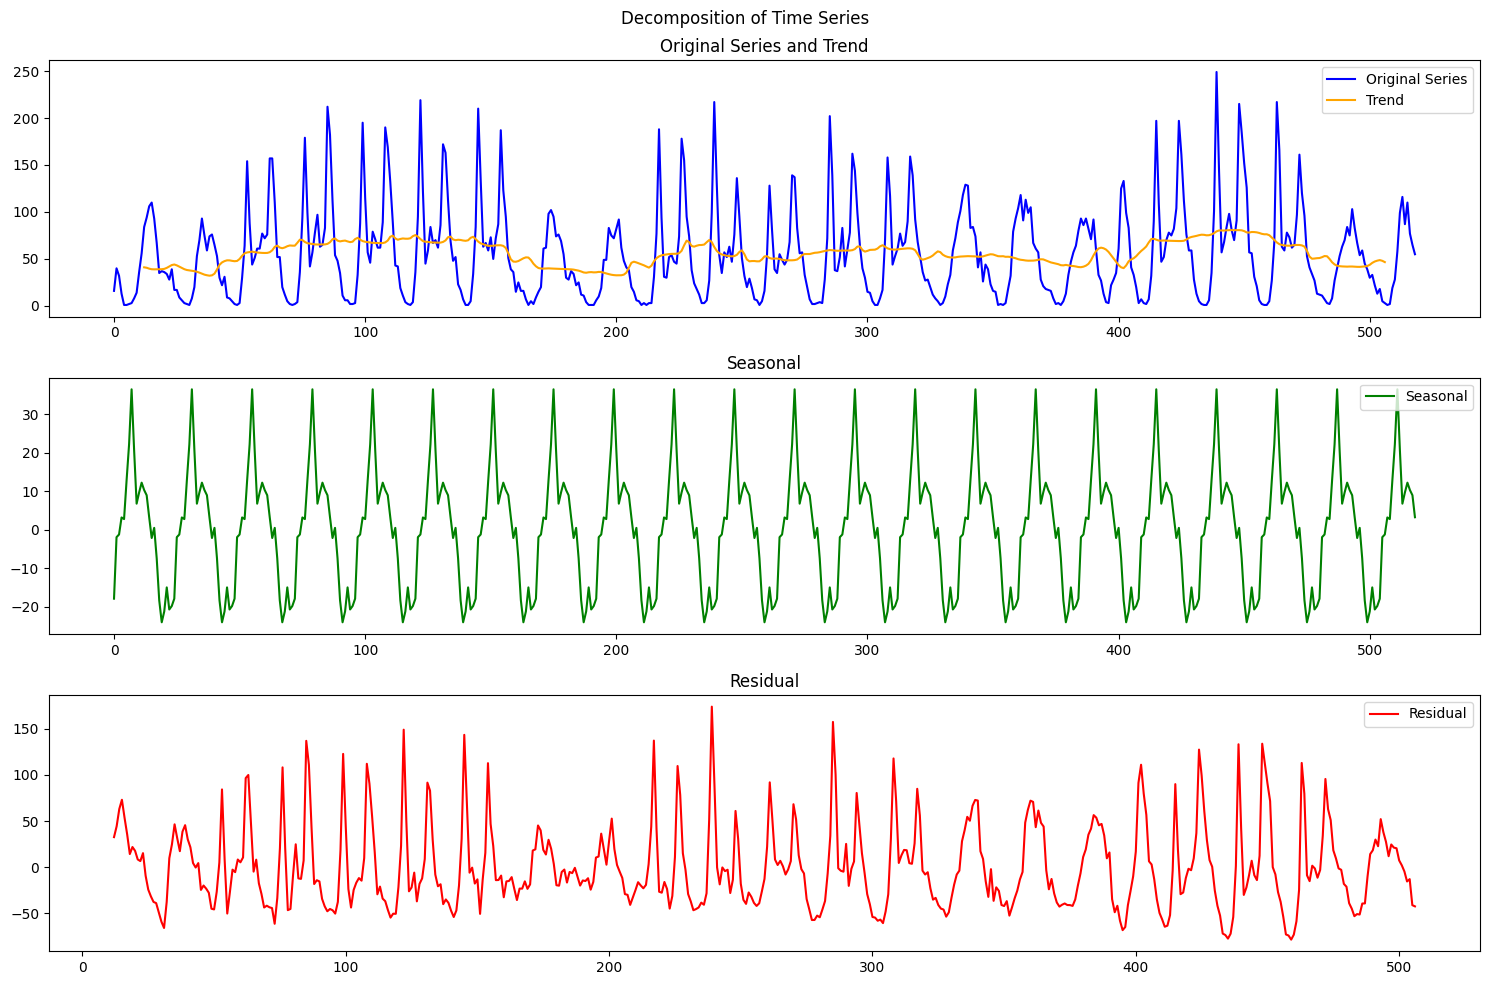

In [15]:
train_dc_1.plot_decomposition(trend, seasonal, residual)

The plot above indicates a distinct **seasonal pattern** with a periodicity of approximately **one day**, suggesting a temporal influence on the **`cnt`** variable. However, there is no apparent trend in the data, which suggests that the dataset may already be stationary. This assumption will be further tested using the **Augmented Dickey-Fuller (ADF) test** in subsequent analysis.  

## 2.5 Inspecting time specific relations

In [16]:
train_data = fc.create_timeseries_features(train_data)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   year         16637 non-null  int64         
 9   month        16637 non-null  int64         
 10  week         16637 non-null  int64         
 11  day          16637 non-null  int64         
 12  hour         16637 non-null  int64         
 13  day_of_week  16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 1.8 MB


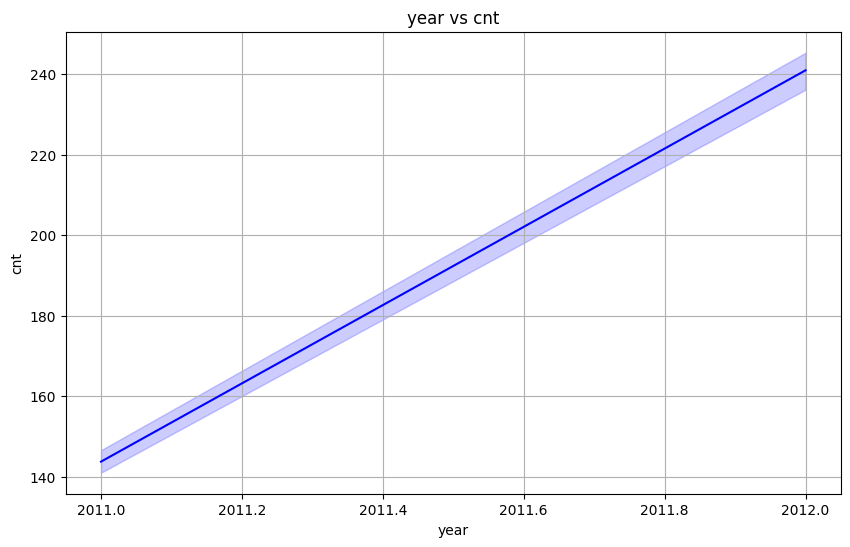

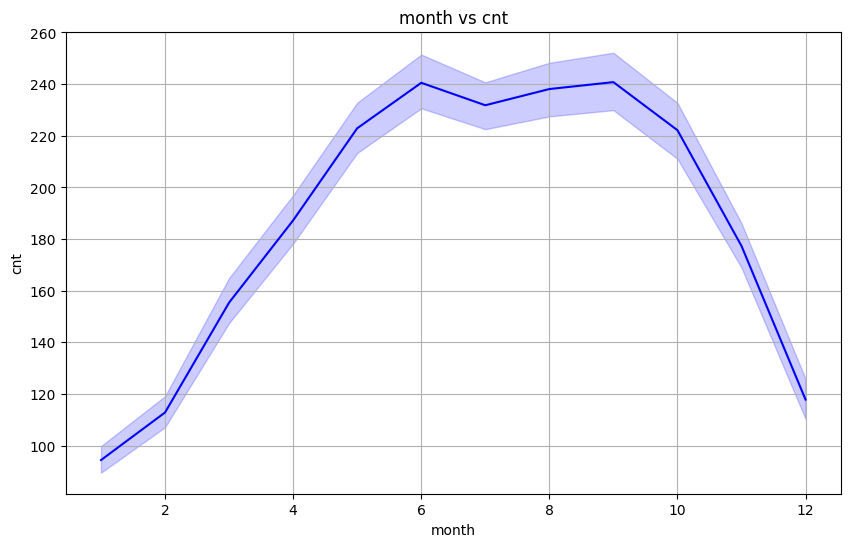

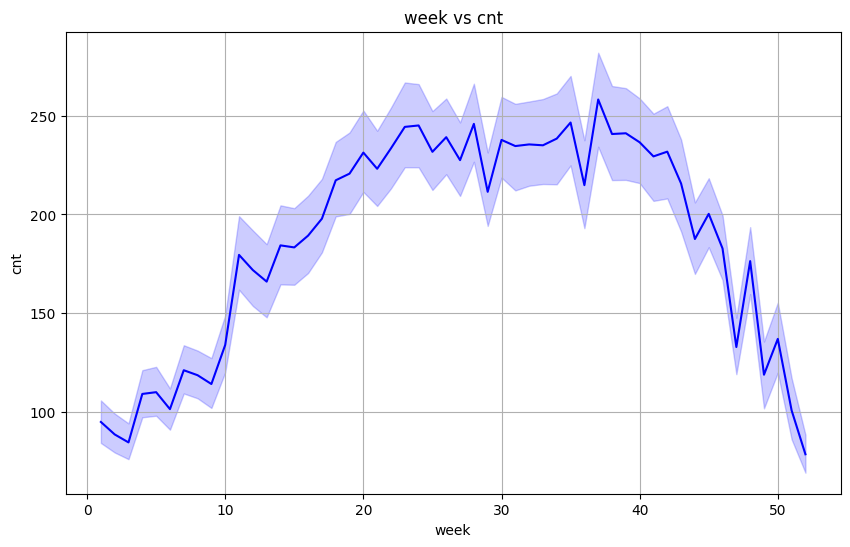

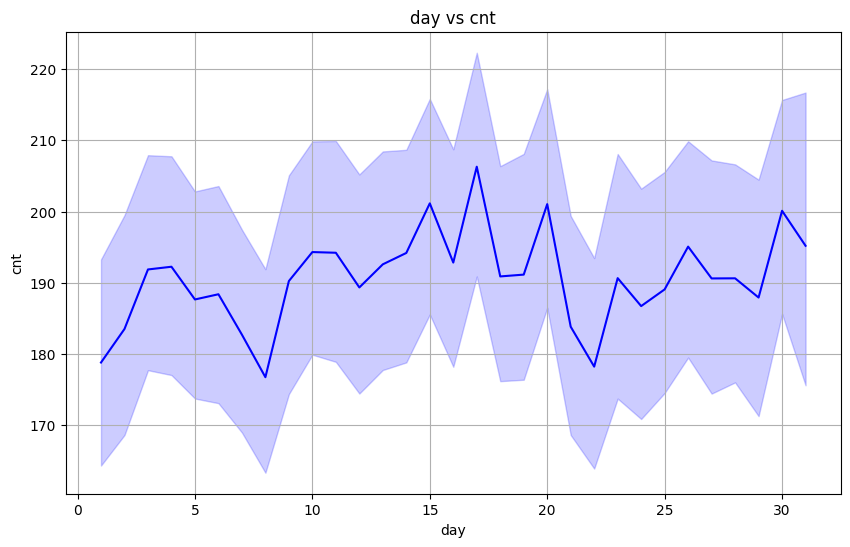

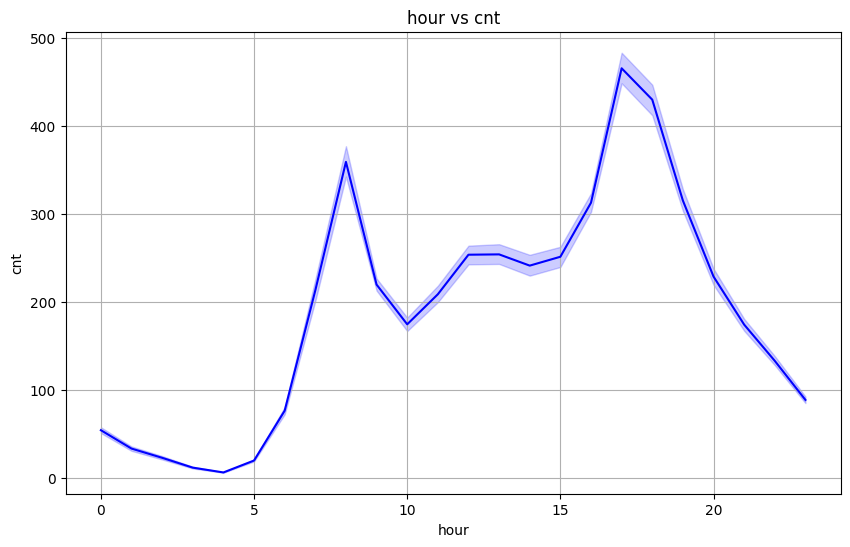

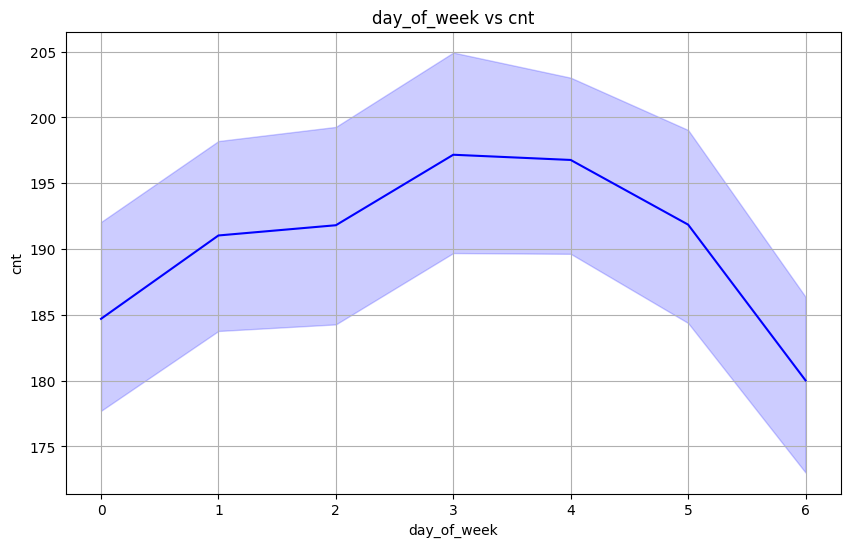

In [18]:
cols = ['year', 'month', 'week', 'day', 'hour', 'day_of_week']

for col in cols:
    dv_train.lineplot(x=col, y='cnt', title=f'{col} vs cnt', path=f'Figures/{col}_vs_cnt.png')

The analysis of the above plots reveals the following insights:  
- Over the two-year period, the average value of `cnt` has shown an upward trend. Since there is no real added value in this column since we are working over just two years, this column will be dropped  
- The monthly and weekly graphs demonstrate a distinct peak in `cnt` during the summer months. Since in both of the columns the same trends can be observed, the month column will be dropped.
- The day-of-the-month graph does not exhibit a clear correlation. Therefore, this column will be dropped.
- The hour-of-the-day graph shows pronounced peaks during the morning and evening hours.  
- The day-of-the-week graph indicates noticeable peaks on the fourth and fifth days of the week.

## 2.6 Stationarity

To assess whether the dataset exhibits stationarity, we will perform the Augmented Dickey-Fuller (ADF) test. This statistical test evaluates the null hypothesis ($H_0$) that the data contains a unit root, indicating non-stationarity. Rejection of the null hypothesis suggests that the data is stationary.

**Hypothesis:**

- $H_0$: The data contains a unit root and is non-stationary.
- $H_1$: The data does not contain a unit root and is stationary.

**Results:**

The outcome of the ADF test includes:
- The test statistic, which is compared against critical values at various significance levels (e.g., 1%, 5%, 10%).
- The p-value, indicating the probability of observing the test statistic under the null hypothesis.

Based on these results, we will determine if stationarity can be assumed for the dataset or if additional transformations (e.g., differencing) are necessary to achieve stationarity.


In [19]:
stat_tests = fc.StatisticalTests(train_data)

In [20]:
stat_tests.stationary_test('cnt')

ADF Statistic: -6.625164793721716
p-value: 5.901288668679553e-09
Critical Values: {'1%': -3.430744160906401, '5%': -2.8617142032973706, '10%': -2.5668627239973634}

Reject the null hypothesis, the data is stationary


## 2.7 Fourier analysis

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

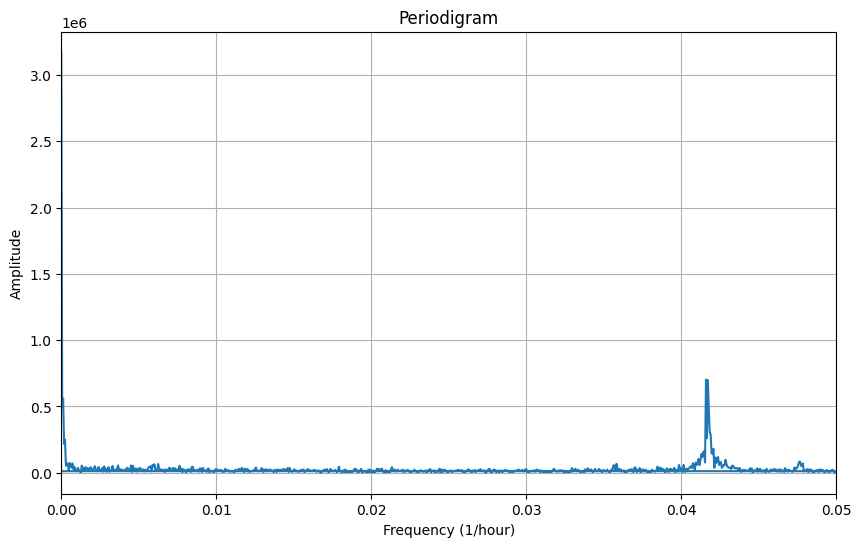

,amplitude,freq,duur in uren,duur in dagen
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859


In [21]:
stat_tests.fourier_analysis('cnt')

The Fourier analysis reveals two prominent frequency spikes:

1. A spike at a frequency of approximately **0.0001**, which corresponds to a periodicity of roughly **one year**.  
2. A second spike at a frequency of approximately **0.041**, which translates to a periodicity of approximately **24 hours**.

These findings suggest the presence of annual and daily patterns in the dataset, which may be significant for time series modeling. 

## 2.8 Autocorrelation

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

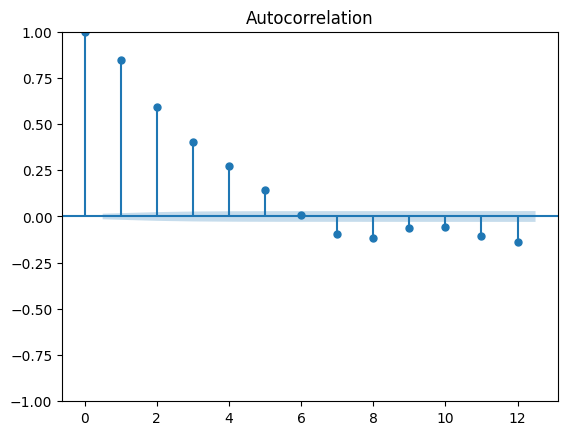

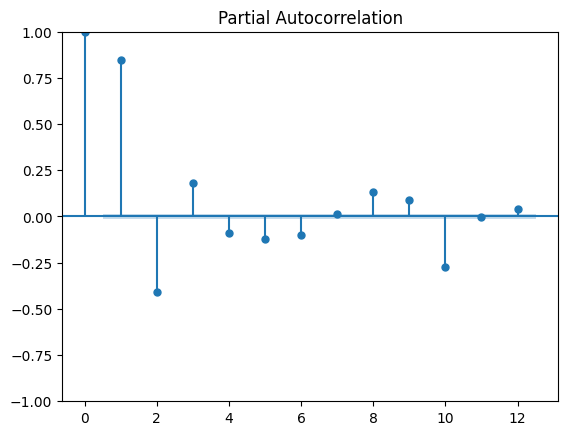

In [22]:
plot_acf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/ACF.png')
plt.show()

plot_pacf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/PACF.png')
plt.show()

Based on the combined autocorrelation and partial autocorrelation plots, we observe significant correlations up to **lag 5**. This indicates that past values within this lag range have a meaningful relationship with the current value, which may be important for time series modeling.

## 2.9 Conclusion

The exploratory data analysis (EDA) has provided valuable insights into the dataset, its structure, and the relationships between features. Based on the findings, the following data preprocessing steps will be applied to prepare the dataset for further analysis and modeling:

1. **Column Dropping**:
   - The following columns will be removed as they either lack meaningful contribution, exhibit high correlation with other features, or show redundant information:
     - `holiday`: Weak correlation with the target variable and limited predictive power.
     - `year`, `month`, `day_of_week`, `day`: These columns demonstrate trends or patterns already captured by other features, such as `hour` or aggregated time-series patterns.
     - `atemp`: Highly correlated with `temp` (0.99), making it redundant.
     - `windspeed`: Weak correlation with the target variable, indicating limited linear influence.

2. **Dummy Variable Creation**:
   - Dummy variables will be created for the `weathersit` column to capture its categorical nature effectively and ensure its compatibility with predictive modeling.

3. **Feature Engineering with Fourier Analysis**:
   - Fourier waves will be generated based on the following columns to capture their periodicity:
     - `week` (annual periodicity).
     - `hour` (daily periodicity).
   - After generating the Fourier waves, the original `week` and `hour` columns will be dropped.

4. **Indexing**:
   - The `date_hour` column will be converted to the `datetime` format and set as the index for the dataset to facilitate time series analysis.

These steps will ensure the dataset is optimized for modeling by retaining meaningful features, addressing redundancy, and incorporating temporal patterns effectively.


## 2.10 Updating `test_data`

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [23]:
test_data = fc.create_timeseries_features(test_data)

# 3. Feature engineering

In [24]:
cols_to_drop = ['holiday', 'year', 'month', 'day_of_week', 'day', 'atemp', 'windspeed']
cols_to_dummy = ['weathersit']
cols_to_fourier = ['hour', 'week']
index_col = 'date_hour'

fe = fc.FeatureEngineering(train_data, test_data, cols_to_drop, cols_to_dummy, cols_to_fourier, index_col)

## 3.1 Dropping columns

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [25]:
fe.drop_columns()

Dropping columns: ['holiday', 'year', 'month', 'day_of_week', 'day', 'atemp', 'windspeed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   year         16637 non-null  int64         
 9   month        16637 non-null  int64         
 10  week         16637 non-null  int64         
 11  day          16637 non-null  int64         
 12  hour         16637 non-null  int64         
 13  day_of_week  16637 non-null  int64         
dtypes: datetime

## 3.2 Creating dummies

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [26]:
fe.create_dummies()

Creating dummies for columns: ['weathersit']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   weathersit  16637 non-null  int64         
 2   temp        16637 non-null  float64       
 3   hum         16637 non-null  float64       
 4   cnt         16637 non-null  int64         
 5   week        16637 non-null  int64         
 6   hour        16637 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 910.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   456 non-null    datetime64[ns]
 1   weathersit  456 non-null    int64         
 2   temp        456 non-null    float64       


## 3.3 Creating fourier waves

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

Creating Fourier waves for columns: ['hour', 'week']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_hour     16637 non-null  datetime64[ns]
 1   temp          16637 non-null  float64       
 2   hum           16637 non-null  float64       
 3   cnt           16637 non-null  int64         
 4   week          16637 non-null  int64         
 5   hour          16637 non-null  int64         
 6   weathersit_1  16637 non-null  uint8         
 7   weathersit_2  16637 non-null  uint8         
 8   weathersit_3  16637 non-null  uint8         
 9   weathersit_4  16637 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(3), uint8(4)
memory usage: 845.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---

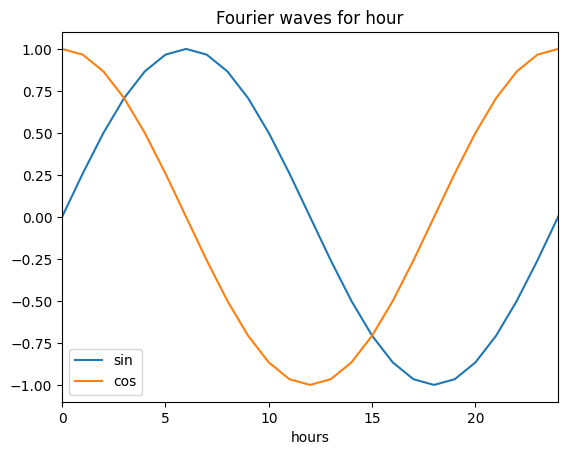

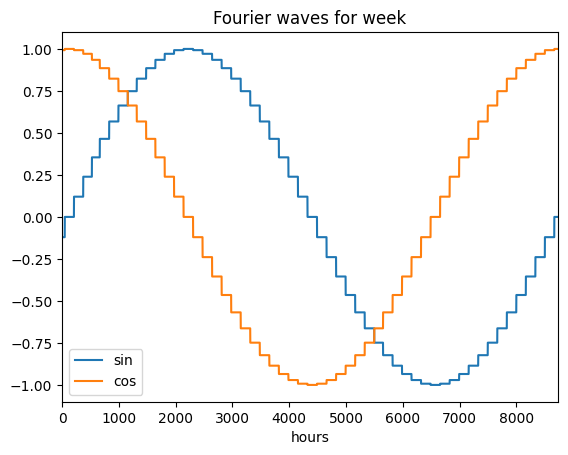

Fourier waves created
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_hour     16637 non-null  datetime64[ns]
 1   temp          16637 non-null  float64       
 2   hum           16637 non-null  float64       
 3   cnt           16637 non-null  int64         
 4   weathersit_1  16637 non-null  uint8         
 5   weathersit_2  16637 non-null  uint8         
 6   weathersit_3  16637 non-null  uint8         
 7   weathersit_4  16637 non-null  uint8         
 8   hour_sin      16637 non-null  float64       
 9   hour_cos      16637 non-null  float64       
 10  week_sin      16637 non-null  float64       
 11  week_cos      16637 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), uint8(4)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (tota

In [27]:
fe.fourier_wave()

## 3.4 Setting index

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [28]:
train_data, test_data = fe.set_index()

In [29]:
train_data.head()

,temp,hum,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.81,16,1,0,0,0,0.000000,1.000000,-0.120537,0.992709
2011-01-01 01:00:00,0.22,0.80,40,1,0,0,0,0.258819,0.965926,-0.120537,0.992709
2011-01-01 02:00:00,0.22,0.80,32,1,0,0,0,0.500000,0.866025,-0.120537,0.992709
2011-01-01 03:00:00,0.24,0.75,13,1,0,0,0,0.707107,0.707107,-0.120537,0.992709
2011-01-01 04:00:00,0.24,0.75,1,1,0,0,0,0.866025,0.500000,-0.120537,0.992709


In [30]:
test_data.head()

,temp,hum,weathersit_1,weathersit_2,weathersit_3,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,
2012-12-01 00:00:00,0.26,0.81,1,0,0,0.000000,1.000000,-0.568065,0.822984
2012-12-01 01:00:00,0.26,0.81,1,0,0,0.258819,0.965926,-0.568065,0.822984
2012-12-01 02:00:00,0.26,0.81,0,1,0,0.500000,0.866025,-0.568065,0.822984
2012-12-01 03:00:00,0.26,0.81,0,1,0,0.707107,0.707107,-0.568065,0.822984
2012-12-01 04:00:00,0.26,0.81,1,0,0,0.866025,0.500000,-0.568065,0.822984


In the training data, a dummy column named **`weathersit_4`** has been created, but it is absent in the test data. Since the **`weathersit`** variable takes values ranging from 1 to 4, the absence of **`weathersit_4`** in the test data indicates that this category is not represented. 

To ensure consistency between the training and test datasets, we can safely drop the **`weathersit_4`** column from the training data without any loss of information.

In [31]:
train_data.drop('weathersit_4', axis=1, inplace=True)

In [32]:
train_data.head()

,temp,hum,cnt,weathersit_1,weathersit_2,weathersit_3,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.81,16,1,0,0,0.000000,1.000000,-0.120537,0.992709
2011-01-01 01:00:00,0.22,0.80,40,1,0,0,0.258819,0.965926,-0.120537,0.992709
2011-01-01 02:00:00,0.22,0.80,32,1,0,0,0.500000,0.866025,-0.120537,0.992709
2011-01-01 03:00:00,0.24,0.75,13,1,0,0,0.707107,0.707107,-0.120537,0.992709
2011-01-01 04:00:00,0.24,0.75,1,1,0,0,0.866025,0.500000,-0.120537,0.992709


# 4. Modelling

## 4.1 Regular models

### 4.1.1 Linear Regression

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [33]:
lr = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False]}

gs = fc.GridSearch(train_data, test_data, target='cnt', model=lr, param_grid=param_grid, n_splits=5, order=1)
gs.fit()
gs.predict(test_data_pred_col)
gs.to_csv(model='lr', path_add=f'order_1')

Best parameters: {'copy_X': True, 'fit_intercept': False}, Best score: -173.88225641633434


### 4.2 KNN Regressor

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [34]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}

gs = fc.GridSearch(train_data, test_data, target='cnt', model=knn, param_grid=param_grid, n_splits=5, order=None)
gs.fit()
gs.predict(test_data_pred_col)
gs.to_csv(model='knn', path_add=f'order_None')

Best parameters: {'n_neighbors': 5, 'weights': 'distance'}, Best score: -168.82147640606235


### 4.3 Decision Tree Regressor

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [35]:
dt = DecisionTreeRegressor()
param_grid = {'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 3, 4, 5]}

gs = fc.GridSearch(train_data, test_data, target='cnt', model=dt, param_grid=param_grid, n_splits=5, order=1)
gs.fit()
gs.predict(test_data_pred_col)
gs.to_csv(model='dt', path_add=f'order_1')

Best parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}, Best score: -142.96085800819353


### 4.4 Random Forest Regressor

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [36]:
rf = RandomForestRegressor()
param_grid = {'n_estimators': [25, 50, 75, 100], 'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 3, 4, 5]}

gs = fc.GridSearch(train_data, test_data, target='cnt', model=rf, param_grid=param_grid, n_splits=5, order=1)
gs.fit()
gs.predict(test_data_pred_col)
gs.to_csv(model='rf', path_add=f'order_1')

Best parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 25}, Best score: -132.00318648199698


### 4.5 XGB Regressor

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [37]:
xgb = XGBRegressor()
param_grid = {'n_estimators': [25, 50, 75, 100], 'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0], 'subsample': [0.01, 0.1, 0.3, 0.5, 0.7, 1], 'colsample_bytree': [0.01, 0.1, 0.3, 0.5, 0.7, 1]}

gs = fc.GridSearch(train_data, test_data, target='cnt', model=xgb, param_grid=param_grid, n_splits=5, order=1)
gs.fit()
gs.predict(test_data_pred_col)
gs.to_csv(model='xgb', path_add=f'order_1')

Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}, Best score: -121.47544112453443


Following the initial evaluation of all models:  

- **Order 1 and Order 2** models performed significantly better than the model with no order.  
- The difference in performance between **Order 1** and **Order 2** models was negligible.  
- For the **KNN model**, however, the model with **no order** yielded the best performance.  

As a result, we will proceed with **Order 1** for all subsequent analyses to maintain simplicity without sacrificing accuracy, except for the **KNN model**, where we will use **no order**.

## 4.2 Timeseries models

### 4.2.1 SARIMAX

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [ ]:
y = train_data['cnt']

param_grid = {'order': [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1), (3, 0, 0), (3, 0, 1)],
              'seasonal_order': [(0, 0, 0, 24), (0, 0, 1, 24), (1, 0, 0, 24), (1, 0, 1, 24), (2, 0, 0, 24), (2, 0, 1, 24), (3, 0, 0, 24), (3, 0, 1, 4)}

sarimax_model = fc.SARIMAXModel(y, param_grid)
sarimax_model.grid_search()

sarimax_model.fit_final_model()

start_date = test_data_pred_col[0]
end_date = test_data_pred_col[-1]

sarimax_model.predict(start_date, end_date, test_data_pred_col)

sarimax_model.to_csv()

GridSearch iterations:   0%|          | 0/168 [00:00<?, ?it/s]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:   1%|          | 1/168 [00:00<00:26,  6.19it/s]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppD

Error with {'order': (0, 0, 0), 'seasonal_order': (4, 0, 1, 24)}: Unable to allocate 1.14 GiB for an array with shape (96, 96, 16637) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:   7%|▋         | 11/168 [34:17<18:42:54, 429.14s/it]

Error with {'order': (0, 0, 0), 'seasonal_order': (5, 0, 0, 24)}: Unable to allocate 15.2 MiB for an array with shape (120, 1, 16637) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GridSearch iterations:   7%|▋         | 12/168 [1:05:51<37:53:52, 874.57s/it]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mode

Error with {'order': (0, 0, 0), 'seasonal_order': (5, 0, 1, 24)}: Unable to allocate 15.2 MiB for an array with shape (120, 1, 16637) and data type float64


GridSearch iterations:   8%|▊         | 13/168 [1:12:19<31:18:31, 727.17s/it]

Error with {'order': (0, 0, 0), 'seasonal_order': (6, 0, 0, 24)}: Unable to allocate 2.57 GiB for an array with shape (144, 144, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:   8%|▊         | 14/168 [1:29:49<35:17:09, 824.87s/it]

Error with {'order': (0, 0, 0), 'seasonal_order': (6, 0, 1, 24)}: Unable to allocate 2.57 GiB for an array with shape (144, 144, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:   9%|▉         | 15/168 [1:29:51<24:30:30, 576.67s/it]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\s

Error with {'order': (0, 0, 1), 'seasonal_order': (3, 0, 1, 4)}: LU decomposition error.


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GridSearch iterations:  14%|█▎        | 23/168 [2:26:51<39:54:20, 990.76s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (4, 0, 0, 24)}: Unable to allocate 1.14 GiB for an array with shape (96, 96, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  14%|█▍        | 24/168 [2:42:00<38:39:12, 966.34s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (4, 0, 1, 24)}: LU decomposition error.


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  15%|█▍        | 25/168 [3:01:25<40:45:16, 1025.99s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (5, 0, 0, 24)}: Unable to allocate 1.78 GiB for an array with shape (120, 120, 16637) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  15%|█▌        | 26/168 [4:05:41<73:57:53, 1875.16s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (5, 0, 1, 24)}: LU decomposition error.


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GridSearch iterations:  16%|█▌        | 27/168 [4:42:01<77:01:06, 1966.43s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (6, 0, 0, 24)}: Unable to allocate 2.57 GiB for an array with shape (144, 144, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  17%|█▋        | 28/168 [5:43:13<96:22:24, 2478.18s/it]

Error with {'order': (0, 0, 1), 'seasonal_order': (6, 0, 1, 24)}: LU decomposition error.


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  17%|█▋        | 29/168 [5:43:13<66:59:02, 1734.84s/it]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Error with {'order': (1, 0, 0), 'seasonal_order': (4, 0, 0, 24)}: Unable to allocate 1.17 GiB for an array with shape (97, 97, 16637) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  23%|██▎       | 38/168 [6:18:23<20:19:53, 563.03s/it]

Error with {'order': (1, 0, 0), 'seasonal_order': (4, 0, 1, 24)}: Unable to allocate 1.17 GiB for an array with shape (97, 97, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
GridSearch iterations:  23%|██▎       | 39/168 [6:38:30<27:06:12, 756.38s/it]

Error with {'order': (1, 0, 0), 'seasonal_order': (5, 0, 0, 24)}: Unable to allocate 1.81 GiB for an array with shape (121, 121, 16638) and data type float64


c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GridSearch iterations:  24%|██▍       | 40/168 [7:15:53<42:44:34, 1202.14s/it]c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mod

Error with {'order': (1, 0, 0), 'seasonal_order': (5, 0, 1, 24)}: Unable to allocate 1.81 GiB for an array with shape (121, 121, 16638) and data type float64


GridSearch iterations:  24%|██▍       | 40/168 [7:35:38<24:18:01, 683.45s/it] 


KeyboardInterrupt: 

### 4.2.2 Prophet

<div style="border: 2px solid red; background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; display: inline-block; max-width: 97%;">
    <strong>Warning:</strong> ADD DESCRIPTION!!!
</div>

In [ ]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'yearly_seasonality': ['auto', True, False],
              'weekly_seasonality': ['auto', True, False],
              'daily_seasonality': ['auto', True, False]}

prophet_model = fc.ProphetModel(train_data, param_grid=param_grid)
prophet_model.grid_search()

prophet_model.fit_final_model()

prophet_model.predict(test_data=test_data, periods=len(test_data), freq='H')

prophet_model.save_predictions()

GridSearch iterations:   0%|          | 0/162 [00:00<?, ?it/s]18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   1%|          | 1/162 [00:02<06:07,  2.29s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   1%|          | 2/162 [00:06<08:34,  3.22s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': 'auto', 'yearly_seasonality': True}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   2%|▏         | 3/162 [00:08<07:22,  2.79s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': 'auto', 'yearly_seasonality': False}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   2%|▏         | 4/162 [00:10<06:54,  2.63s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': 'auto'}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   3%|▎         | 5/162 [00:15<08:30,  3.25s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   4%|▎         | 6/162 [00:17<07:37,  2.93s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': False}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   4%|▍         | 7/162 [00:19<06:51,  2.65s/it]

Error with {'changepoint_prior_scale': 0.01, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': 'auto'}: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`


GridSearch iterations:   4%|▍         | 7/162 [00:20<07:28,  2.90s/it]


KeyboardInterrupt: 